In [31]:
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))


GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Veri artırmayı çeşitlendirme
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.2
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Eğitim veri yükleyicisi
train_generator = train_datagen.flow_from_directory(
    'Organized_Damage_Level/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Validasyon veri yükleyicisi
validation_generator = valid_datagen.flow_from_directory(
    'Organized_Damage_Level/valid',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# MobileNet tabanlı model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Daha fazla katman eğitilebilir hale getirildi
base_model.trainable = True
for layer in base_model.layers[:20]:  # İlk 20 katmanı dondur
    layer.trainable = False

# Modelin son katmanlarını oluşturma
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(2048, activation='relu', kernel_regularizer=l2(0.01))(x)  # Kapasite artırıldı
x = Dropout(0.4)(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.4)(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Modeli derleme
model.compile(optimizer=Adam(learning_rate=5e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


Found 3427 images belonging to 4 classes.
Found 1096 images belonging to 4 classes.


In [33]:
# 4. Modeli Daha Uzun Süre Eğitme
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=60,  # Daha uzun eğitim
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/60
108/108 [==============================] - 27s 232ms/step - loss: 27.2069 - accuracy: 0.4981 - val_loss: 25.7982 - val_accuracy: 0.5255 - lr: 5.0000e-05
Epoch 2/60
108/108 [==============================] - 24s 224ms/step - loss: 24.5790 - accuracy: 0.5719 - val_loss: 23.4135 - val_accuracy: 0.5602 - lr: 5.0000e-05
Epoch 3/60
108/108 [==============================] - 24s 223ms/step - loss: 22.3152 - accuracy: 0.5959 - val_loss: 21.1912 - val_accuracy: 0.5995 - lr: 5.0000e-05
Epoch 4/60
108/108 [==============================] - 24s 223ms/step - loss: 20.2541 - accuracy: 0.6119 - val_loss: 19.2076 - val_accuracy: 0.6442 - lr: 5.0000e-05
Epoch 5/60
108/108 [==============================] - 24s 224ms/step - loss: 18.4109 - accuracy: 0.6236 - val_loss: 17.5116 - val_accuracy: 0.6141 - lr: 5.0000e-05
Epoch 6/60
108/108 [==============================] - 24s 224ms/step - loss: 16.7388 - accuracy: 0.6358 - val_loss: 15.9124 - val_accuracy: 0.6496 - lr: 5.0000e-05
Epoch 7/60
108/1

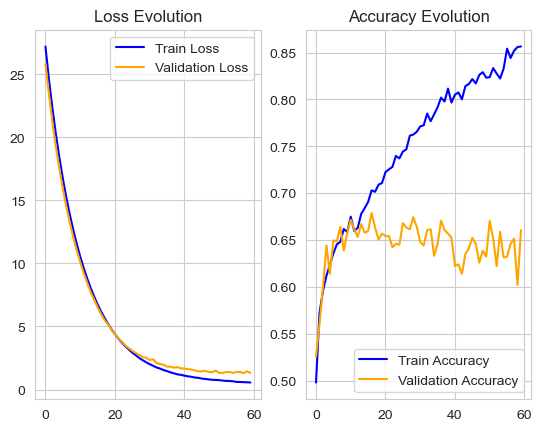

In [34]:
# Kayıp değerleri
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.legend()
plt.title('Loss Evolution')

# Doğruluk değerleri
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

In [35]:
# Validasyon verisi üzerinde tahmin yapma
validation_generator.reset()
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Gerçek etiketler
y_true = validation_generator.classes


35/35 [==============================] - 2s 42ms/step


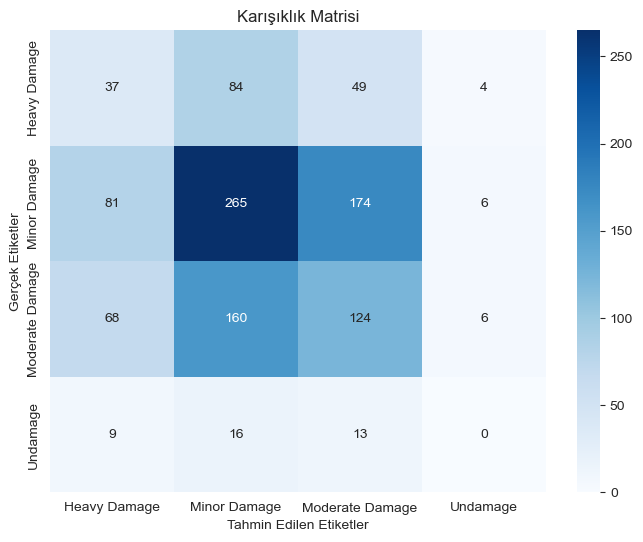

Sınıflandırma Raporu:
                  precision    recall  f1-score   support

   Heavy Damage       0.19      0.21      0.20       174
   Minor Damage       0.50      0.50      0.50       526
Moderate Damage       0.34      0.35      0.35       358
       Undamage       0.00      0.00      0.00        38

       accuracy                           0.39      1096
      macro avg       0.26      0.27      0.26      1096
   weighted avg       0.38      0.39      0.39      1096



In [36]:
# Karışıklık matrisi
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(validation_generator.class_indices.keys()), yticklabels=list(validation_generator.class_indices.keys()))
plt.xlabel('Tahmin Edilen Etiketler')
plt.ylabel('Gerçek Etiketler')
plt.title('Karışıklık Matrisi')
plt.show()

# Sınıflandırma raporu
report = classification_report(y_true, predicted_classes, target_names=list(validation_generator.class_indices.keys()))
print("Sınıflandırma Raporu:\n", report)